In [1]:
!ls -l ../data/*.csv

-rw-rw-r-- 1 ivan sudo   21736219 Dec  2  2019 ../data/clients.csv
-rw-r--r-- 1 ivan sudo   21257426 May 25 10:33 ../data/clients_target.csv
-rw-rw-r-- 1 ivan sudo    3890339 Dec  2  2019 ../data/products.csv
-rw-rw-r-- 1 ivan sudo 4463775504 Dec  2  2019 ../data/purchases.csv
-rw-r--r-- 1 ivan sudo     440186 May 25 10:55 ../data/test_ids.csv
-rw-rw-r-- 1 ivan sudo    6057851 Dec  2  2019 ../data/uplift_sample_submission.csv
-rw-rw-r-- 1 ivan sudo    2201363 Dec  2  2019 ../data/uplift_test.csv
-rw-rw-r-- 1 ivan sudo    3000616 Dec  2  2019 ../data/uplift_train.csv


In [2]:
import pickle
import sys

In [3]:
import numpy as np
import pandas as pd

In [4]:
pd.options.display.float_format = '{:,.3f}'.format

In [5]:
import matplotlib.pyplot as plt

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from IPython.display import display

In [8]:
sys.path.append('../../../')

In [9]:
def np_ewa(x, *alphas):
    assert len(x.shape) == 2
    n = len(x)
    mask = np.triu(np.ones((n, n)))
    w = np.eye(n)
    p = (np.arange(n).reshape(1, -1) - np.arange(n).reshape(-1, 1))
    for a in alphas:
        _w = (1 - a) ** p * mask
        _w = _w / _w.sum(axis=0, keepdims=True)
        w = np.dot(w, _w)
    return np.dot(x.T, w).T

In [10]:
def np_log_sign(x):
    return np.log1p(np.abs(x)) * np.sign(x)

In [11]:
df_products = pd.read_csv('../data/products.csv')

In [12]:
df_trx = pd.read_csv('../data/purchases.csv')

In [13]:
df_products.head()

product_id     level_1     level_2     level_3     level_4  segment_id  \
0  0003020d3c  c3d3a8e8c6  c2a3ea8d5e  b7cda0ec0c  6376f2a852     123.000   
1  0003870676  e344ab2e71  52f13dac0c  d3cfe81323  6dc544533f     105.000   
2  0003ceaf69  c3d3a8e8c6  f2333c90fb  419bc5b424  f6148afbc0     271.000   
3  000701e093  ec62ce61e3  4202626fcb  88a515c084  48cf3d488f     172.000   
4  0007149564  e344ab2e71  52f13dac0c  d3cfe81323  6dc544533f     105.000   

     brand_id   vendor_id  netto  is_own_trademark  is_alcohol  
0  394a54a7c1  9eaff48661  0.400                 0           0  
1  acd3dd483f  10486c3cf0  0.680                 0           0  
2  f597581079  764e660dda  0.500                 0           0  
3  54a90fe769  03c2d70bad  0.112                 0           0  
4  63417fe1f3  f329130198  0.600                 0           0

In [14]:
df_trx.head()

client_id transaction_id transaction_datetime  regular_points_received  \
0  000012768d     7e3e2e3984  2018-12-01 07:12:45                   10.000   
1  000012768d     7e3e2e3984  2018-12-01 07:12:45                   10.000   
2  000012768d     7e3e2e3984  2018-12-01 07:12:45                   10.000   
3  000012768d     7e3e2e3984  2018-12-01 07:12:45                   10.000   
4  000012768d     7e3e2e3984  2018-12-01 07:12:45                   10.000   

   express_points_received  regular_points_spent  express_points_spent  \
0                    0.000                 0.000                 0.000   
1                    0.000                 0.000                 0.000   
2                    0.000                 0.000                 0.000   
3                    0.000                 0.000                 0.000   
4                    0.000                 0.000                 0.000   

   purchase_sum    store_id  product_id  product_quantity  trn_sum_from_iss  \
0     1,007.000  54a4a11a29  9a80204f78             2.000            80.000   
1     1,007.000  54a4a11a29  da89ebd374             1.000            65.000   
2     1,007.000  54a4a11a29  0a95e1151d             1.000            24.000   
3     1,007.000  54a4a11a29  4055b15e4a             2.000            50.000   
4     1,007.000  54a4a11a29  a685f1916b             1.000            22.000   

   trn_sum_from_red  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN

In [15]:
df_trx['transaction_datetime'] = pd.to_datetime(df_trx['transaction_datetime'])

In [16]:
df_trx['dt'] = df_trx['transaction_datetime'].dt.floor('D')

In [17]:
df_trx = pd.merge(df_trx, df_products, on='product_id', how='left')

min        2018-11-21 00:00:00
max        2019-03-18 00:00:00
nunique                    118
Name: dt, dtype: object


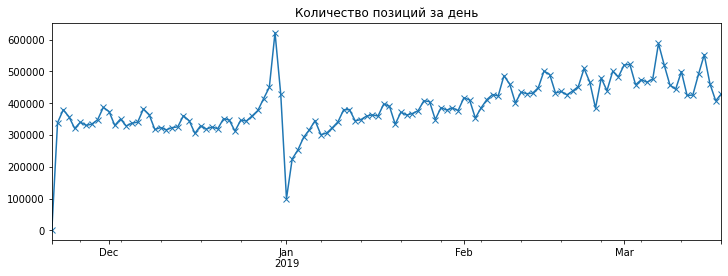

In [18]:
print(df_trx['dt'].agg(['min', 'max', 'nunique']))

df_trx['dt'].value_counts().sort_index() \
.plot(figsize=(12, 4), marker='x', title='Количество позиций за день')
plt.show()

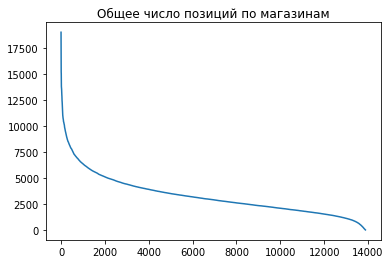

In [19]:
df_trx['store_id'].value_counts().reset_index(drop=True).plot(title='Общее число позиций по магазинам')
plt.show()

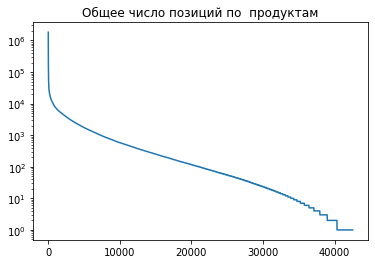

In [20]:
df_trx['product_id'].value_counts().reset_index(drop=True) \
.plot(title='Общее число позиций по  продуктам', logy=True)
plt.show()

In [21]:
df_trx['level_1'].value_counts()

e344ab2e71    25989977
c3d3a8e8c6    18400065
ec62ce61e3     1390052
Name: level_1, dtype: int64

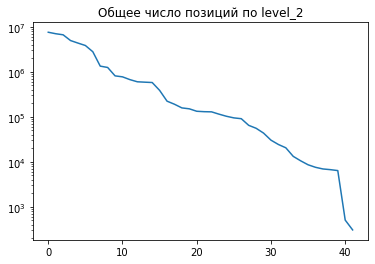

In [22]:
df_trx['level_2'].value_counts().reset_index(drop=True) \
.plot(title='Общее число позиций по level_2', logy=True)
plt.show()

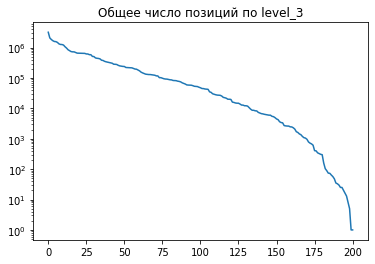

In [23]:
df_trx['level_3'].value_counts().reset_index(drop=True) \
.plot(title='Общее число позиций по level_3', logy=True)
plt.show()

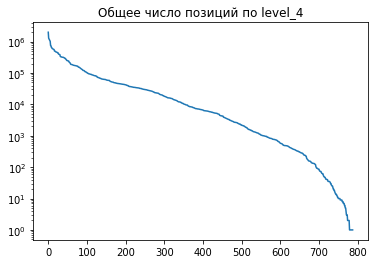

In [24]:
df_trx['level_4'].value_counts().reset_index(drop=True) \
.plot(title='Общее число позиций по level_4', logy=True)
plt.show()

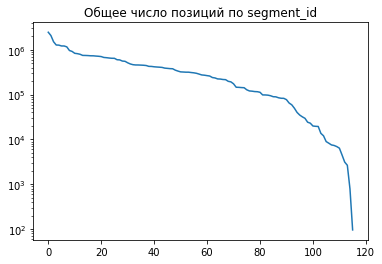

In [25]:
df_trx['segment_id'].value_counts().reset_index(drop=True) \
.plot(title='Общее число позиций по segment_id', logy=True)
plt.show()

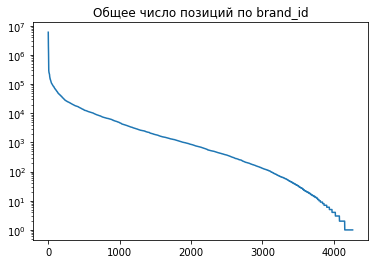

In [26]:
df_trx['brand_id'].value_counts().reset_index(drop=True) \
.plot(title='Общее число позиций по brand_id', logy=True)
plt.show()

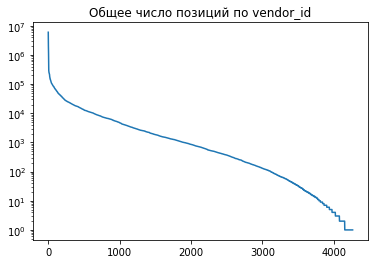

In [27]:
df_trx['brand_id'].value_counts().reset_index(drop=True) \
.plot(title='Общее число позиций по vendor_id', logy=True)
plt.show()

In [28]:
df_trx['is_own_trademark'].value_counts()

0    38807738
1     6978830
Name: is_own_trademark, dtype: int64

In [29]:
df_trx['is_alcohol'].value_counts()

0    45016044
1      770524
Name: is_alcohol, dtype: int64

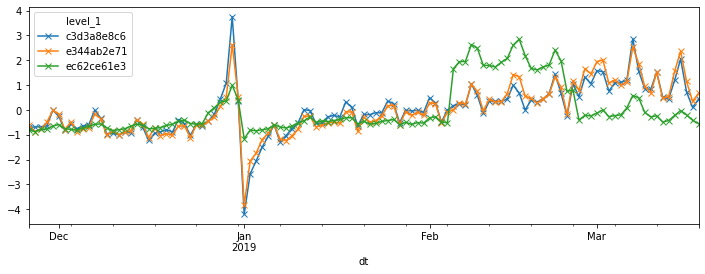

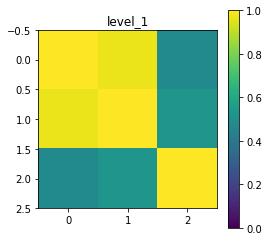

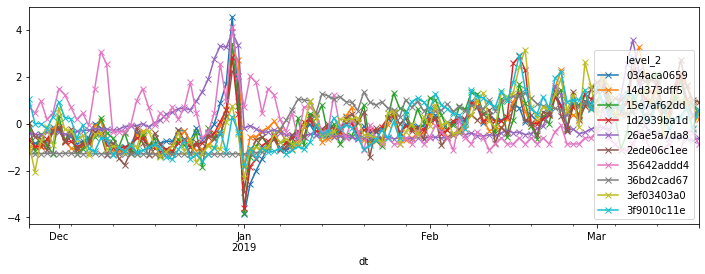

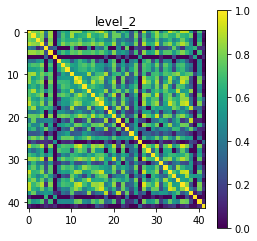

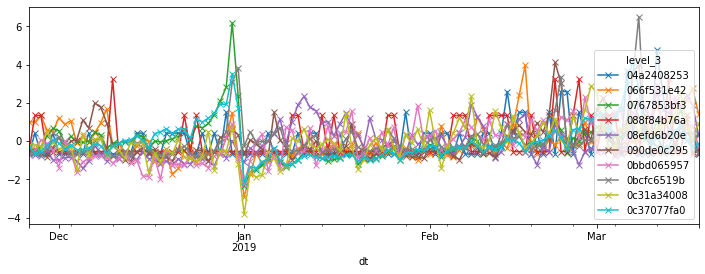

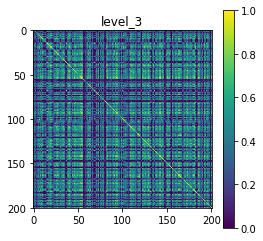

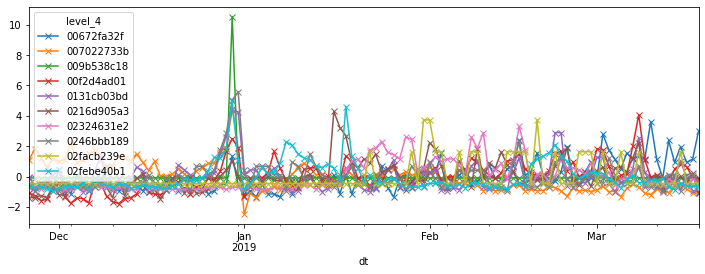

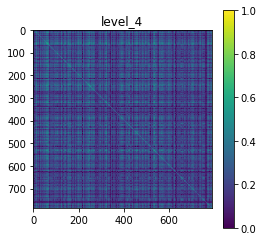

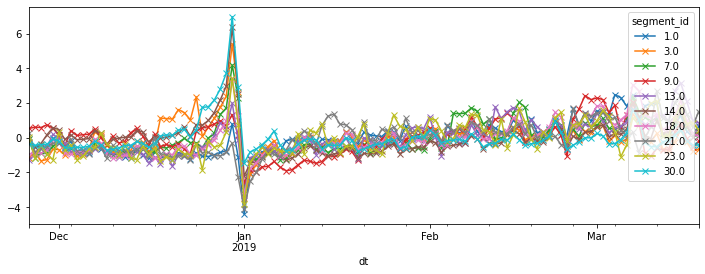

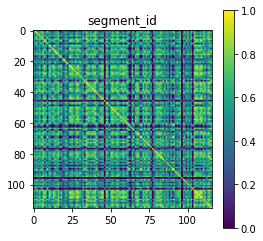

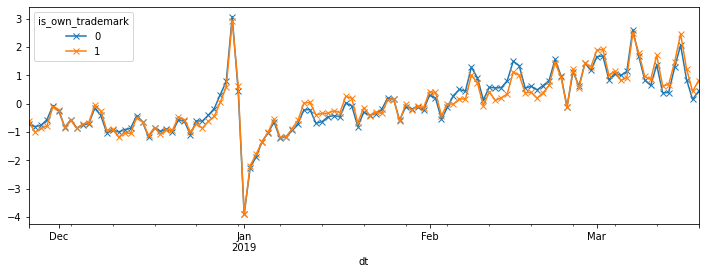

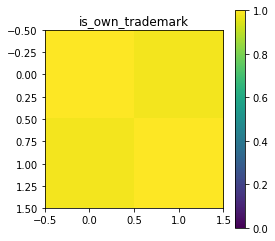

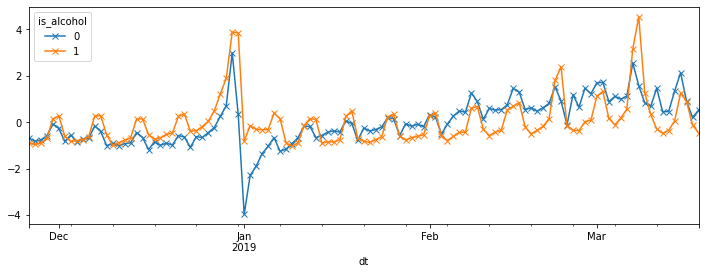

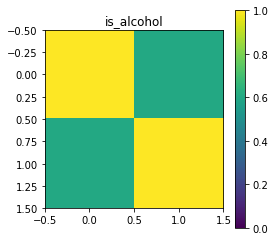

In [30]:
for col in ['level_1', 'level_2', 'level_3', 'level_4', 'segment_id', 'is_own_trademark', 'is_alcohol']:
    df = df_trx.pivot_table(index='dt', columns=col, values='product_id', aggfunc=len) \
    .sort_index().asfreq('D').fillna(0).iloc[5:]
    df = df - df.mean(axis=0)
    df = df / df.std(axis=0)
    if len(df.columns) > 10:
        df.iloc[:, :10].plot(figsize=(12, 4), marker='x')
    else:
        df.plot(figsize=(12, 4), marker='x')
    plt.show()

    plt.figure(figsize=(4, 4))
    plt.imshow(np.dot(df.values.T, df.values) / (len(df) - 1), vmin=0, vmax=1)
    plt.colorbar()
    plt.title(col)
    plt.show()

# Пробуем разбивку по магазинам

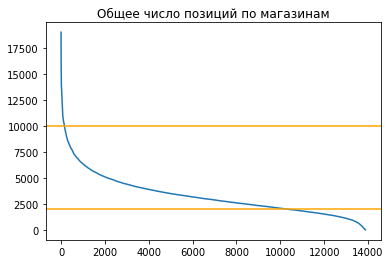

In [31]:
df_trx['store_id'].value_counts().reset_index(drop=True).plot(title='Общее число позиций по магазинам')
plt.axhline(2000, color='orange')
plt.axhline(10000, color='orange')
plt.show()

In [32]:
ix_store_middle = df_trx['store_id'].value_counts()[lambda x: x.between(2000, 10000)].index.tolist()

In [33]:
ix_store_ood = df_trx['store_id'].value_counts()[lambda x: ~x.between(2000, 10000)].index.tolist()

In [34]:
df_trx_middle_store = df_trx[lambda x: x['store_id'].isin(ix_store_middle)].copy()

In [35]:
print('Selected {} trx from {} total ({:.1f}%)'.format(
    len(df_trx_middle_store), len(df_trx), len(df_trx_middle_store) / len(df_trx) * 100))

Selected 39019723 trx from 45786568 total (85.2%)


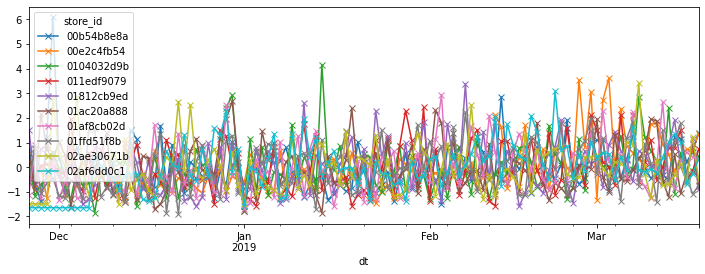

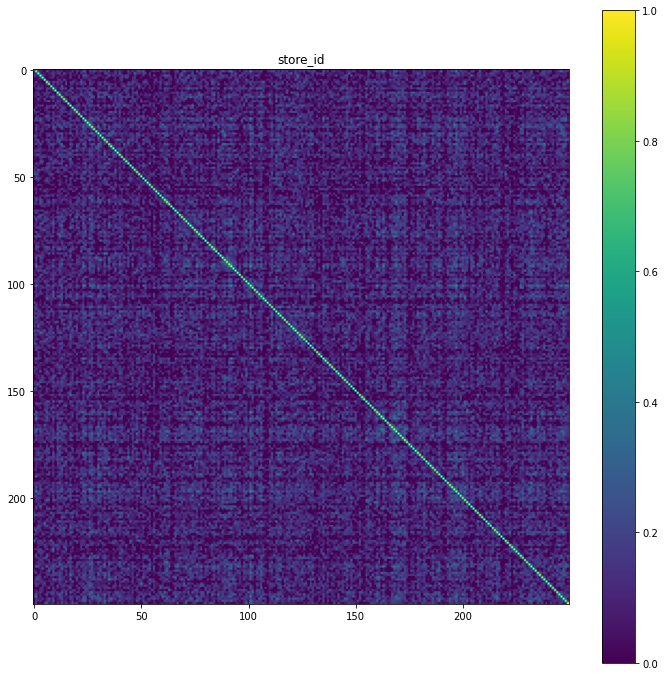

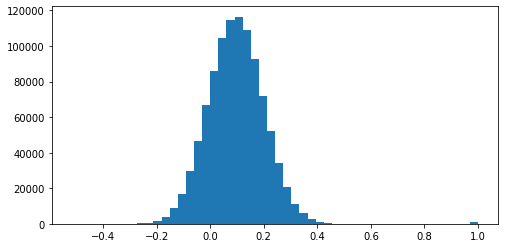

In [36]:
col = 'store_id'
df = df_trx_middle_store[lambda x: x['store_id'].isin(np.random.choice(ix_store_middle, 1000, replace=False))] \
    .pivot_table(index='dt', columns=col, values='product_id', aggfunc=len) \
.sort_index().asfreq('D').fillna(0).iloc[5:]
df = df - df.mean(axis=0)
df = df / df.std(axis=0)
df.iloc[:, :10].plot(figsize=(12, 4), marker='x')
plt.show()

plt.figure(figsize=(12, 12))
plt.imshow(np.dot(df.values.T, df.values)[:250][:, :250] / (len(df) - 1), vmin=0, vmax=1)
plt.colorbar()
plt.title(col)
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(np.dot(df.values.T, df.values).flatten() / (len(df) - 1), bins=50)
plt.show()

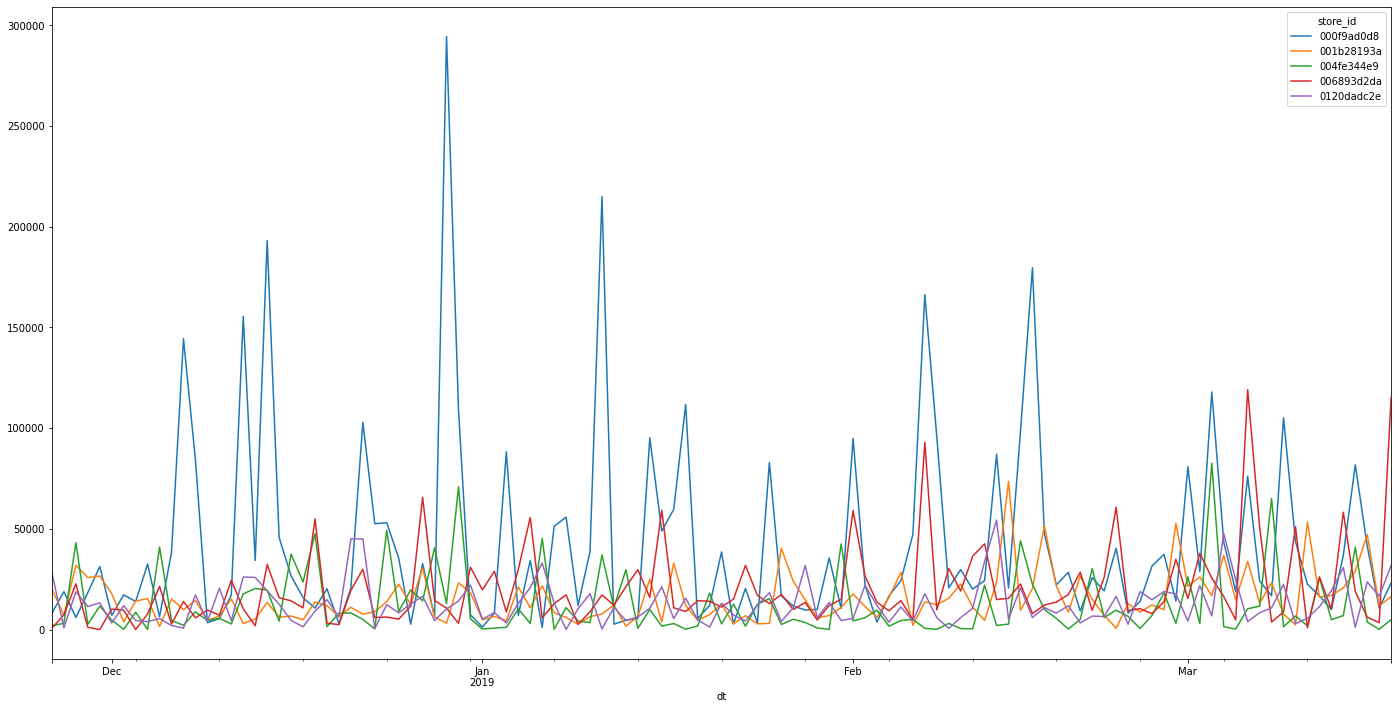

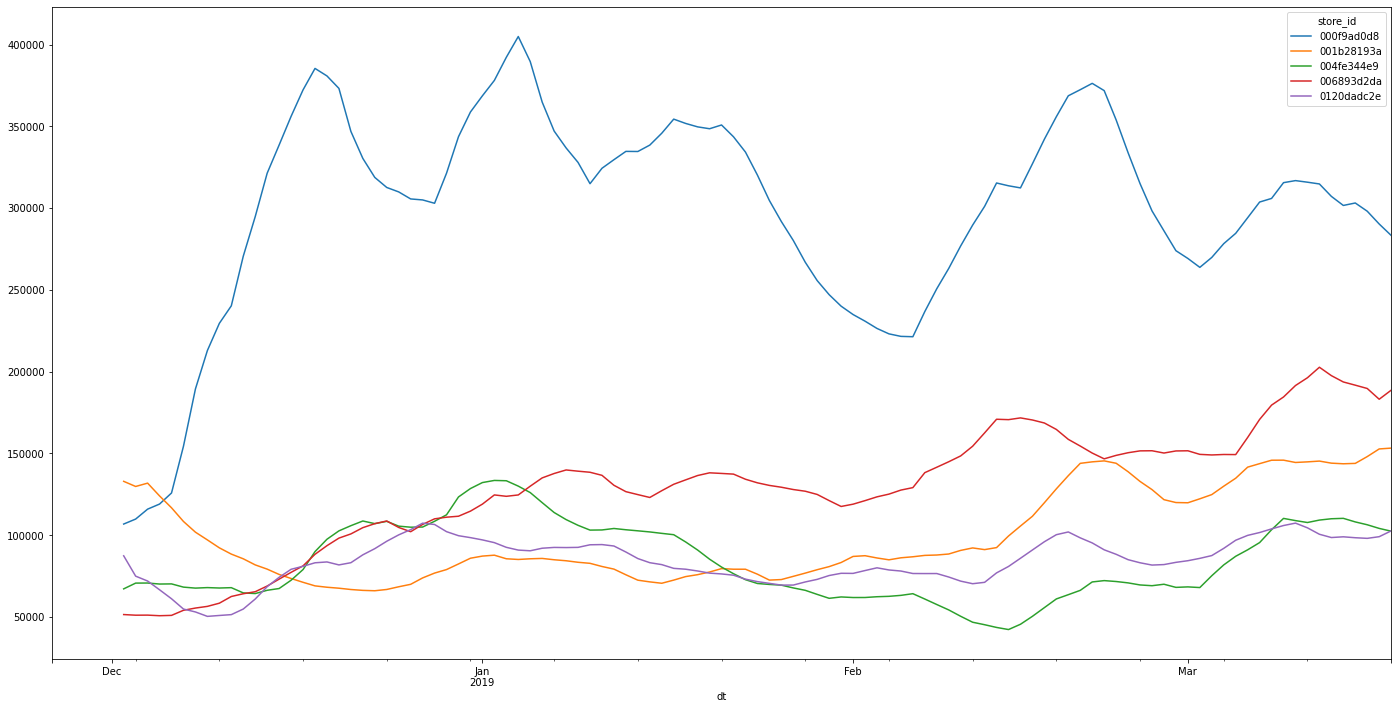

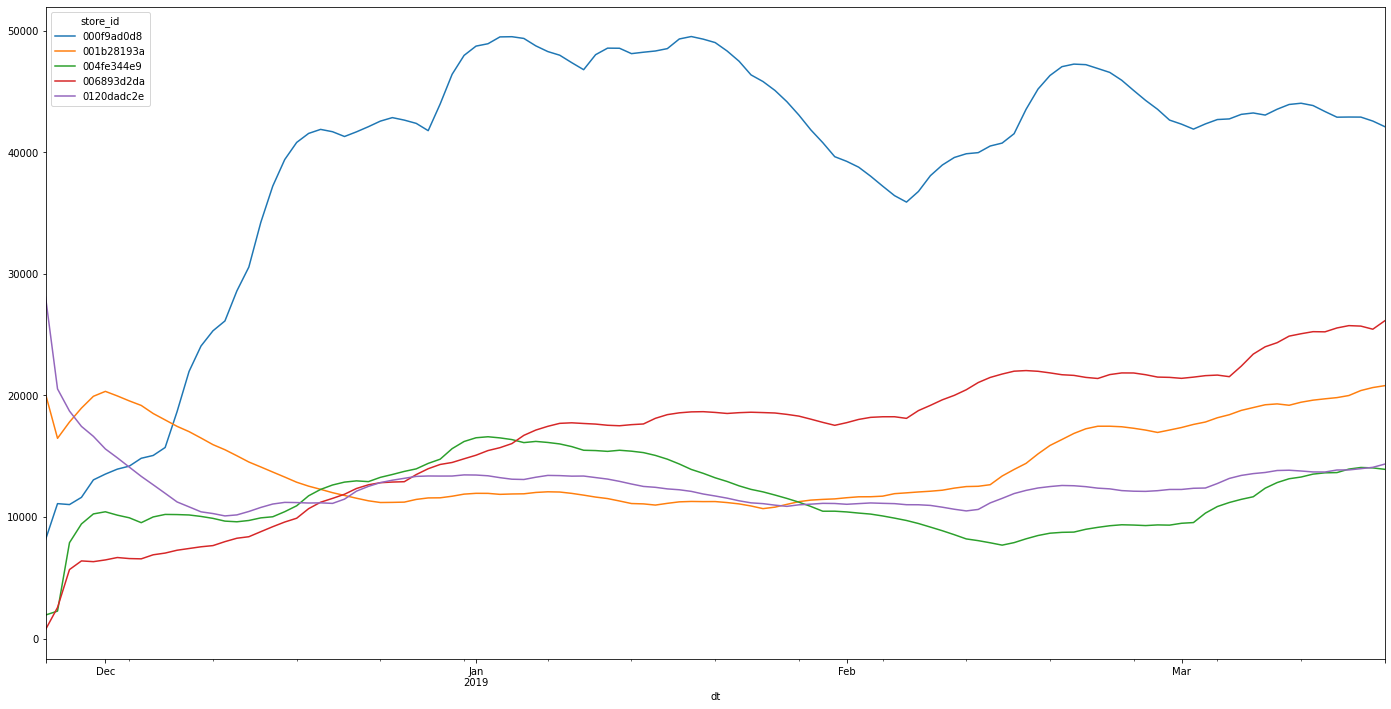

In [37]:
df = df_trx_middle_store[lambda x: x['store_id'].isin(np.random.choice(ix_store_middle, 1000, replace=False))] \
    .pivot_table(index='dt', columns=col, values='purchase_sum', aggfunc=sum) \
.sort_index().asfreq('D').fillna(0).iloc[5:]
# df = df - df.mean(axis=0)
# df = df / df.std(axis=0)
df.iloc[:, :5].plot(figsize=(24, 12))
plt.show()
df.iloc[:, :5].rolling(7).sum().ewm(alpha=0.1).mean().plot(figsize=(24, 12))
plt.show()
df.iloc[:, :5].ewm(alpha=0.1).mean().ewm(alpha=0.1).mean().plot(figsize=(24, 12))
plt.show()


In [38]:
df_targets = df_trx.groupby(['store_id', 'dt'])[['purchase_sum']].sum().sort_index()
df_targets = df_targets.groupby(level='store_id').apply(
    lambda x: x.reset_index('store_id', drop=True).asfreq('D').fillna(0))

df_targets['y1'] = df_targets.groupby(level='store_id')['purchase_sum'].shift(-1)

df_targets['y1_mean'] = df_targets.groupby('store_id').apply(
    lambda x: x.reset_index('store_id', drop=True)['purchase_sum'].ewm(alpha=0.2).mean().ewm(alpha=0.2).mean())

df_targets = df_targets[~df_targets.isna().any(axis=1)]

In [39]:
df_targets.head()

purchase_sum         y1   y1_mean
store_id   dt                                           
000407ff98 2018-11-22     4,527.000  1,527.300 4,527.000
           2018-11-23     1,527.300 11,851.820 3,601.167
           2018-11-24    11,851.820      0.000 4,807.847
           2018-11-25         0.000  3,283.710 4,645.354
           2018-11-26     3,283.710  4,767.200 4,458.572

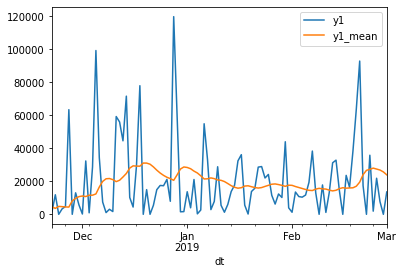

In [40]:
df_targets[['y1', 'y1_mean']] \
.iloc[:100].reset_index('store_id', drop=True).plot()
plt.show()

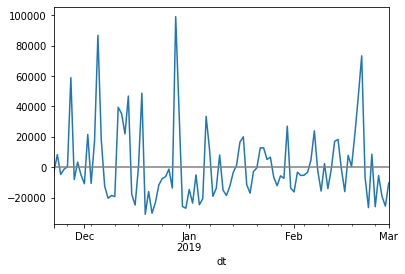

In [41]:
(df_targets['y1'] - df_targets['y1_mean']) \
.iloc[:100].reset_index('store_id', drop=True).plot()
plt.axhline(0, color='gray')
plt.show()

In [42]:
df_ar = pd.concat([df_targets.groupby('store_id')['purchase_sum'].shift(i).rename(f'ar_{i:02d}')
                   for i in range(28)], axis=1)
df_ar_mean = df_ar.groupby('store_id').apply(
    lambda x: x.reset_index('store_id', drop=True).ewm(alpha=0.2).mean().ewm(alpha=0.2).mean())

In [43]:
def data_split(df):
    train_stores = df.reset_index('dt')
    train = train_stores[lambda x: x['dt'].lt('2019-02-01')].set_index('dt', append=True)
    valid = train_stores[lambda x: x['dt'].lt('2019-03-01') & x['dt'].ge('2019-02-01')].set_index('dt', append=True)
    test = train_stores[lambda x: x['dt'].ge('2019-03-01')].set_index('dt', append=True)
    return train, valid, test

In [44]:
df_y_train, df_y_valid, df_y_test = data_split(df_targets)

In [45]:
[len(df) for df in data_split(df_targets)]

[950525, 382174, 233265]

In [46]:
df_x_ar_train, df_x_ar_valid, df_x_ar_test = data_split(df_ar)

In [47]:
df_x_ar_mean_train, df_x_ar_mean_valid, df_x_ar_mean_test = data_split(df_ar_mean)

In [48]:
len(ix_store_middle)

10168

In [49]:
ix_store_middle = df_x_ar_train.index.levels[0].intersection(ix_store_middle).tolist()
ix_store_middle = df_x_ar_valid.index.levels[0].intersection(ix_store_middle).tolist()
ix_store_middle = df_x_ar_test.index.levels[0].intersection(ix_store_middle).tolist()

In [50]:
len(ix_store_middle)

10161

In [51]:
len(ix_store_ood)

3714

In [52]:
ix_store_ood = df_x_ar_train.index.levels[0].intersection(ix_store_ood).tolist()
ix_store_ood = df_x_ar_valid.index.levels[0].intersection(ix_store_ood).tolist()
ix_store_ood = df_x_ar_test.index.levels[0].intersection(ix_store_ood).tolist()

In [53]:
len(ix_store_ood)

3421

# Train

In [54]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error

In [55]:
def predict(model, X, y, df_y):
    raw_predict = model.predict(np.clip(X.values, -2.5, 2.5))
    
    predict = pd.concat([
        df_y['y1'].reindex(X.index),
        raw_predict * \
        pd.merge(X[[]], df_y_std.rename('std'), left_index=True, right_index=True, how='left')['std'].values + \
        df_y['y1_mean'].reindex(X.index).rename('predict'),
    ], axis=1)

    sample_store_id = X.index.values[0][0]
    print(sample_store_id)
    _, axs = plt.subplots(1, 3, figsize=(16, 2))
    predict.loc[sample_store_id].plot(ax=axs[0])
    
    s_r2_scores = predict.groupby('store_id').apply(lambda x: r2_score(x['y1'], x['predict']))
    display(s_r2_scores.quantile(np.linspace(0, 1, 11)).to_frame().T)
    
    axs[1].hist(np.clip(y.values, -2.5, 2.5), bins=50, alpha=0.5)
    axs[1].hist(raw_predict, bins=50, alpha=0.5)
    
    axs[2].hist(s_r2_scores, range=(-0.5, 1))
    plt.show()

    return raw_predict, predict

# AR only

In [56]:
df_y_std = (df_y_train['purchase_sum'] - df_y_train['y1_mean']).groupby('store_id').std()
df_y_std = df_y_std.fillna(0).where(lambda x: x > 1, 1)

In [57]:
X_train = (df_x_ar_train - df_x_ar_mean_train) / \
pd.merge(df_x_ar_train[[]], df_y_std.rename('std'), left_index=True, right_index=True, how='left').values

X_valid = (df_x_ar_valid - df_x_ar_mean_valid) / \
pd.merge(df_x_ar_valid[[]], df_y_std.rename('std'), left_index=True, right_index=True, how='left').values

X_test = (df_x_ar_test - df_x_ar_mean_test) / \
pd.merge(df_x_ar_test[[]], df_y_std.rename('std'), left_index=True, right_index=True, how='left').values

In [58]:
X_train.shape, X_valid.shape, X_test.shape

((950525, 28), (382174, 28), (233265, 28))

In [59]:
history_limit = 28
X_train = X_train.iloc[:, :history_limit]  # limit history
X_valid = X_valid.iloc[:, :history_limit]  # limit history
X_test = X_test.iloc[:, :history_limit]  # limit history

In [60]:
X_train = X_train[lambda x: ~x.isna().any(axis=1)]
X_valid = X_valid[lambda x: ~x.isna().any(axis=1)]
X_test = X_test[lambda x: ~x.isna().any(axis=1)]

In [61]:
X_train = X_train.loc[X_train.groupby('store_id')['ar_00'].count()[lambda x: x >= 2].index]
X_valid = X_valid.loc[X_valid.groupby('store_id')['ar_00'].count()[lambda x: x >= 2].index]
X_test = X_test.loc[X_test.groupby('store_id')['ar_00'].count()[lambda x: x >= 2].index]

In [62]:
X_train.shape, X_valid.shape, X_test.shape

((584310, 28), (378256, 28), (230062, 28))

In [63]:
y_train = (df_y_train['y1'] - df_y_train['y1_mean']) / \
pd.merge(df_y_train[[]], df_y_std.rename('std'), left_index=True, right_index=True, how='left')['std'].values

y_valid = (df_y_valid['y1'] - df_y_valid['y1_mean']) / \
pd.merge(df_y_valid[[]], df_y_std.rename('std'), left_index=True, right_index=True, how='left')['std'].values

y_test = (df_y_test['y1'] - df_y_test['y1_mean']) / \
pd.merge(df_y_test[[]], df_y_std.rename('std'), left_index=True, right_index=True, how='left')['std'].values

In [64]:
y_train.shape, y_valid.shape, y_test.shape

((950525,), (382174,), (233265,))

In [65]:
y_train = y_train.reindex(X_train.index)
y_valid = y_valid.reindex(X_valid.index)
y_test = y_test.reindex(X_test.index)

In [66]:
y_train.shape, y_valid.shape, y_test.shape

((584310,), (378256,), (230062,))

In [67]:
y_train.isna().sum(), y_valid.isna().sum(), y_test.isna().sum()

(0, 0, 0)

In [68]:
class DummyModel:
    def predict(self, X):
        return np.zeros(len(X))
    
reg_dummy = DummyModel()

In [69]:
# reg_model = Ridge(alpha=0.1, fit_intercept=False)
reg_model = LinearRegression()
reg_model.fit(
    np.clip(X_train.loc[ix_store_middle].values, -2.5, 2.5),
    np.clip(y_train.loc[ix_store_middle].values, -2.5, 2.5),
)

LinearRegression()

000407ff98


0.000  0.100  0.200  0.300  0.400  0.500  0.600  0.700  0.800  0.900  1.000
0 -5.763 -0.129 -0.111 -0.100 -0.092 -0.085 -0.078 -0.070 -0.060 -0.045  0.130

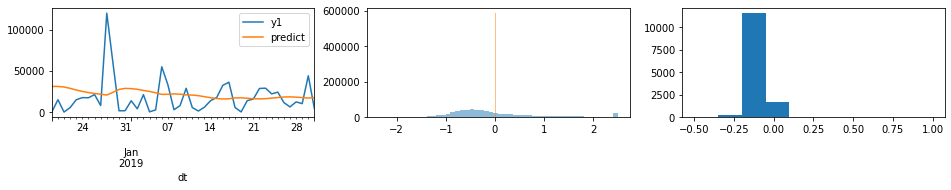

000407ff98


0.000  0.100  0.200  0.300  0.400  0.500  0.600  0.700  0.800  0.900  \
0 -5,985.077 -0.149 -0.122 -0.107 -0.097 -0.088 -0.080 -0.071 -0.062 -0.046   

   1.000  
0  0.097

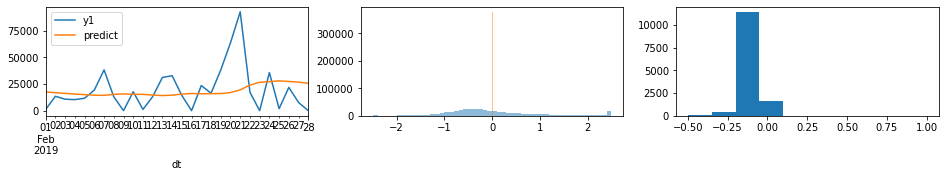

000407ff98


0.000  0.100  0.200  0.300  0.400  0.500  0.600  0.700  0.800  0.900  \
0 -29.479 -0.232 -0.169 -0.138 -0.119 -0.105 -0.093 -0.083 -0.073 -0.062   

   1.000  
0  0.019

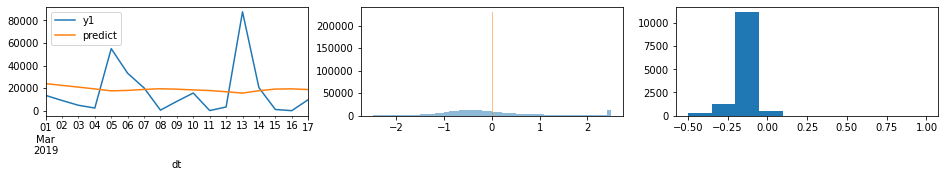

In [70]:
_ = predict(reg_dummy, X_train,
            y_train, df_y_train)
_ = predict(reg_dummy, X_valid,
            y_valid, df_y_valid)
_ = predict(reg_dummy, X_test,
            y_test, df_y_test)

000407ff98


0.000  0.100  0.200  0.300  0.400  0.500  0.600  0.700  0.800  0.900  \
0 -59.389 -0.110 -0.092 -0.081 -0.073 -0.065 -0.058 -0.050 -0.040 -0.025   

   1.000  
0  0.184

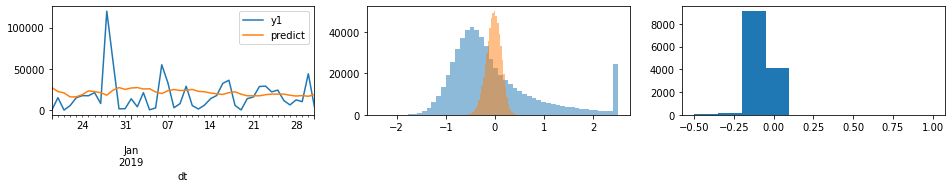

000407ff98


0.000  0.100  0.200  0.300  0.400  0.500  0.600  0.700  0.800  0.900  \
0 -5,986.190 -0.160 -0.126 -0.108 -0.094 -0.083 -0.072 -0.061 -0.048 -0.029   

   1.000  
0  0.118

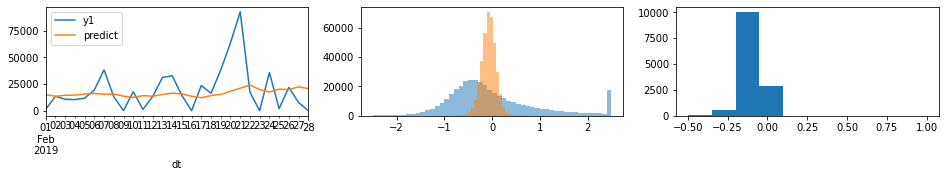

000407ff98


0.000  0.100  0.200  0.300  0.400  0.500  0.600  0.700  0.800  0.900  \
0 -50.391 -0.231 -0.161 -0.127 -0.107 -0.092 -0.078 -0.064 -0.047 -0.023   

   1.000  
0  0.166

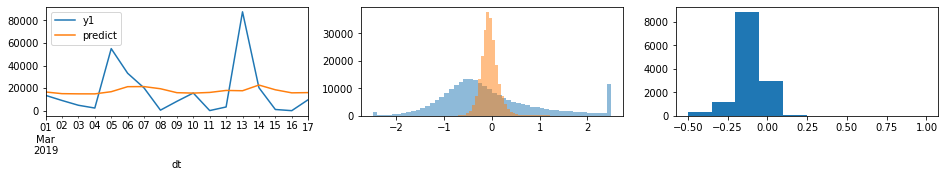

In [71]:
_ = predict(reg_model, X_train,
            y_train, df_y_train)
_ = predict(reg_model, X_valid,
            y_valid, df_y_valid)
_ = predict(reg_model, X_test,
            y_test, df_y_test)

# With features

In [75]:
# %%time
# df_features = df_trx.pivot_table(
#     index=['store_id', 'dt'], columns='level_3',
#     values='purchase_sum', aggfunc=[len, 'sum']
# ).sort_index()

CPU times: user 4min 28s, sys: 23.2 s, total: 4min 51s
Wall time: 4min 51s


In [76]:
# %%time
# with open('df_features.pickle', 'wb') as f:
#     pickle.dump(df_features, f)

CPU times: user 660 ms, sys: 3.75 s, total: 4.41 s
Wall time: 4.41 s


In [74]:
%%time
with open('df_features.pickle', 'rb') as f:
    df_features = pickle.load(f)

EOFError: Ran out of input

In [77]:
df_features = df_features.reindex(df_ar.index).fillna(0)

df_features_mean = df_features.groupby('store_id').apply(
    lambda x: x.reset_index('store_id', drop=True).ewm(alpha=0.2).mean().ewm(alpha=0.2).mean())

In [78]:
df_features_train, df_features_valid, df_features_test = data_split(df_features)
df_features_mean_train, df_features_mean_valid, df_features_mean_test = data_split(df_features_mean)

In [79]:
(
    len(X_train.index.difference(df_features_train.index)),
    len(X_valid.index.difference(df_features_valid.index)),
    len(X_test.index.difference(df_features_test.index)),
)

(0, 0, 0)

In [80]:
df_features_std = (df_features_train - df_features_mean_train).groupby('store_id').std()

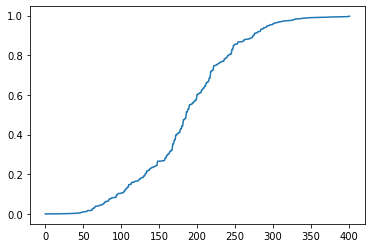

In [81]:
(df_features_std > 0).mean().sort_values().reset_index(drop=True).plot()
plt.show()

In [82]:
used_features = (df_features_std > 0).mean().sort_values().iloc[200:].index

In [83]:
df_features_std = df_features_std.fillna(0).where(lambda x: x > 1, 1)

In [84]:
X_features_train = (df_features_train - 0 * df_features_mean_train) / \
pd.merge(df_features_train[[]], df_features_std, left_index=True, right_index=True)

X_features_valid = (df_features_valid - 0 * df_features_mean_valid) / \
pd.merge(df_features_valid[[]], df_features_std, left_index=True, right_index=True)

X_features_test = (df_features_test - 0 * df_features_mean_test) / \
pd.merge(df_features_test[[]], df_features_std, left_index=True, right_index=True)

In [85]:
X_features_train = X_features_train[used_features]
X_features_valid = X_features_valid[used_features]
X_features_test = X_features_test[used_features]

In [86]:
# X_features_train = X_features_train.reindex(X_train.index)
# X_features_valid = X_features_valid.reindex(X_valid.index)
# X_features_test = X_features_test.reindex(X_test.index)

In [87]:
reg_model = Ridge(alpha=0.1, fit_intercept=False)
# reg_model = LinearRegression()
reg_model.fit(
    np.clip(
        pd.concat([
            X_train,
            X_features_train,
            X_features_train.groupby('store_id').shift(1),
            X_features_train.groupby('store_id').shift(2),
            X_features_train.groupby('store_id').shift(3),
            X_features_train.groupby('store_id').shift(7),
        ], axis=1).reindex(X_train.index).fillna(0).values, -2.5, 2.5),
    np.clip(y_train.values, -2.5, 2.5),
)

Ridge(alpha=0.1, fit_intercept=False)

000407ff98


0.000  0.100  0.200  0.300  0.400  0.500  0.600  0.700  0.800  0.900  \
0 -46.216 -0.106 -0.082 -0.068 -0.056 -0.044 -0.033 -0.020 -0.005  0.018   

   1.000  
0  0.196

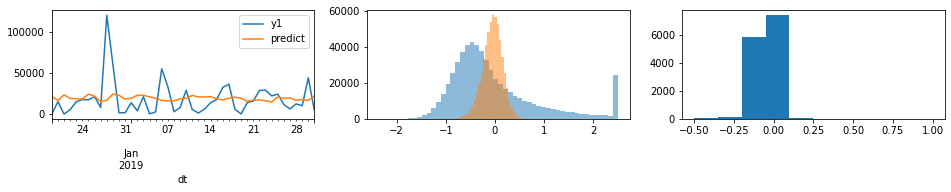

In [88]:
_ = predict(reg_model, pd.concat([
            X_train,
            X_features_train,
            X_features_train.groupby('store_id').shift(1),
            X_features_train.groupby('store_id').shift(2),
            X_features_train.groupby('store_id').shift(3),
            X_features_train.groupby('store_id').shift(7),
        ], axis=1).reindex(X_train.index).fillna(0), y_train, df_y_train)

000407ff98


0.000  0.100  0.200  0.300  0.400  0.500  0.600  0.700  0.800  0.900  \
0 -5,984.459 -0.190 -0.142 -0.117 -0.097 -0.081 -0.066 -0.050 -0.031 -0.003   

   1.000  
0  0.225

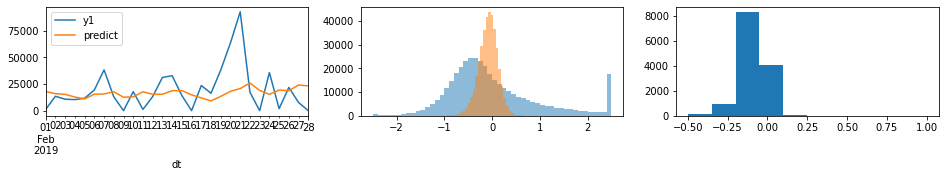

In [89]:
t = predict(reg_model, pd.concat([
            X_valid,
            X_features_valid.iloc[:, :],
            X_features_valid.groupby('store_id').shift(1),
            X_features_valid.groupby('store_id').shift(2),
            X_features_valid.groupby('store_id').shift(3),
            X_features_valid.groupby('store_id').shift(7),
        ], axis=1).reindex(X_valid.index).fillna(0), y_valid, df_y_valid)

000407ff98


0.000  0.100  0.200  0.300  0.400  0.500  0.600  0.700  0.800  0.900  \
0 -34.823 -0.265 -0.187 -0.148 -0.119 -0.097 -0.076 -0.055 -0.031  0.004   

   1.000  
0  0.339

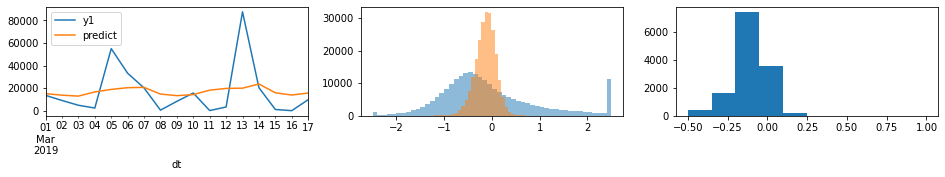

In [90]:
_ = predict(reg_model, pd.concat([
            X_test,
            X_features_test.iloc[:, :],
            X_features_test.groupby('store_id').shift(1),
            X_features_test.groupby('store_id').shift(2),
            X_features_test.groupby('store_id').shift(3),
            X_features_test.groupby('store_id').shift(7),
        ], axis=1).reindex(X_test.index).fillna(0), y_test, df_y_test)

# Embeddings

In [91]:
from ptls.lightning_modules.stream_encoder import *

In [107]:
class StreamEncoder(pl.LightningModule):
    def __init__(self,
                 history_size, predict_size,
                 in_channels, clip_range,
                 z_channels,
                 c_channels,
                 var_gamma_z, var_gamma_c,
                 lr, weight_decay, step_size, gamma,
                 cpc_w, cov_z_w, var_z_w, cov_c_w, var_c_w,
                 plot_samples=[],
                 ):
        super().__init__()

        self.save_hyperparameters()

        self.input_model = InputNorm(in_channels, clip_range)

        self.cnn_encoder = torch.nn.Sequential(
            torch.nn.Linear(in_channels, z_channels),
            TBatchNorm(z_channels),
        )

        self.ar_rnn = torch.nn.GRU(
            input_size=z_channels,
            hidden_size=c_channels,
            batch_first=True,
        )

        self.lin_predictors = torch.nn.ModuleList([
            torch.nn.Linear(c_channels, z_channels) for _ in range(predict_size)
        ])

        self.reg_bn_z = torch.nn.BatchNorm1d(z_channels, affine=False)
        self.reg_bn_c = torch.nn.BatchNorm1d(c_channels, affine=False)

    def configure_optimizers(self):
        optimisers = [torch.optim.Adam(self.parameters(),
                                       lr=self.hparams.lr,
                                       weight_decay=self.hparams.weight_decay,
                                       )]
        schedulers = [torch.optim.lr_scheduler.StepLR(o,
                                                      step_size=self.hparams.step_size,
                                                      gamma=self.hparams.gamma) for o in optimisers]
        return optimisers, schedulers

    def forward(self, x):
        x = self.input_model(x)
        z = self.cnn_encoder(x)
        c, h = self.ar_rnn(z)
        return x, z, c

    def training_step(self, batch, batch_idx):
        x = self.input_model(batch[0])
        z = self.cnn_encoder(x)

        zx, zy = z[:, :self.hparams.history_size], z[:, self.hparams.history_size:]

        cpc_loss, cx = self.cpc_loss(zx, zy)
        cov_z_loss = self.cov_z_loss(zx)
        var_z_loss = self.var_z_loss(zx)
        cov_c_loss = self.cov_c_loss(cx)
        var_c_loss = self.var_c_loss(cx)
        loss = 0.0
        if self.hparams.cpc_w > 0:
            loss += self.hparams.cpc_w * cpc_loss
        if self.hparams.cov_c_w > 0:
            loss += self.hparams.cov_c_w * cov_c_loss
        if self.hparams.var_c_w > 0:
            loss += self.hparams.var_c_w * var_c_loss
        if self.hparams.cov_z_w > 0:
            loss += self.hparams.cov_z_w * cov_z_loss
        if self.hparams.var_z_w > 0:
            loss += self.hparams.var_z_w * var_z_loss

        self.log('loss/cpc', cpc_loss, prog_bar=True)
        self.log('loss/cov_c', cov_c_loss, prog_bar=True)
        self.log('loss/var_c', var_c_loss, prog_bar=True)
        self.log('loss/cov_z', cov_z_loss, prog_bar=True)
        self.log('loss/var_z', var_z_loss, prog_bar=True)
        self.log('loss/loss', loss)

        return loss

    def on_train_start(self):
        self.logger.log_hyperparams(self.hparams, {
            'hp/z_std': 0,
            'hp/dtr': 0,
            'hp/dtt': 0,
            'hp/dlift': 0,
            "hp/zf_cor": 0,
            "hp/ze_cor": 0,
            "hp/cf_cor": 0,
            "hp/ce_cor": 0,
        })

    def plot_xzc(self, x, z, c, log=True):
        x = x[0, :500].detach().cpu().numpy()
        z = z[0, :500].detach().cpu().numpy()
        c = c[0, :500].detach().cpu().numpy()

        # plot signal
        fig, axs = plt.subplots(3, 1, figsize=(12, 4 * 3))
        axs[0].plot(x)
        axs[0].set_title('x signal')
        axs[1].plot(z)
        axs[1].set_title('z signal')
        axs[2].plot(c)
        axs[2].set_title('c signal')
        plt.suptitle('embedding signals')
        if log:
            self.logger.experiment.add_figure('Signals', fig, global_step=self.global_step)
        else:
            plt.show()

        # plot spectrum
        fig, axs = plt.subplots(3, 1, figsize=(12, 3 * 12 * x.shape[1] / x[0, :500].shape[0]))
        axs[0].imshow(x.T)
        axs[0].set_title('x spectrum')
        axs[1].imshow(z.T)
        axs[1].set_title('z spectrum')
        axs[2].imshow(c.T)
        axs[2].set_title('c spectrum')
        if log:
            self.logger.experiment.add_figure('Spectrum', fig, global_step=self.global_step)
        else:
            plt.show()

    def validation_step(self, batch, batch_idx):
        x, z, c = self.forward(batch[0])

        z_std = z.std(dim=1).mean()

        t = torch.randn(10000, 1, device=x.device).repeat(1, z.size(2)) * z_std
        t = t[1:] - t[:-1]
        dtr = t.pow(2).sum(dim=1).pow(0.5).mean()

        history_size = self.hparams.history_size
        dtt = 0.0
        for i, l in enumerate(self.lin_predictors):
            t = z[:, history_size + i:, :]

            p = l(c[:, history_size : z.size(1) - i, :])
            dtt += (p - t).pow(2).sum(dim=1).pow(0.5).mean()
        dtt /= len(self.lin_predictors)

        self.log('hp/z_std', z_std)
        self.log('hp/dtr', dtr)
        self.log('hp/dtt', dtt)
        self.log('hp/dlift', (dtr - dtt) / (dtr + 1e-6))

        x = x - x.mean(dim=1, keepdim=True)
        x = x / (x.std(dim=1, keepdim=True) + 1e-6)
        z = z - z.mean(dim=1, keepdim=True)
        z = z / (z.std(dim=1, keepdim=True) + 1e-6)
        c = c - c.mean(dim=1, keepdim=True)
        c = c / (c.std(dim=1, keepdim=True) + 1e-6)

        m = (torch.bmm(x.transpose(1, 2), z) / x.size(1)).abs()  # B, x, z
        self.log('hp/zf_cor', m.max(dim=2).values.mean())
        self.log('hp/ze_cor', m.max(dim=1).values.mean())

        m = (torch.bmm(x.transpose(1, 2), c) / x.size(1)).abs()  # B, x, c
        self.log('hp/cf_cor', m.max(dim=2).values.mean())
        self.log('hp/ce_cor', m.max(dim=1).values.mean())

    def cpc_loss(self, x, y):
        out, h = self.ar_rnn(x)
        c = out[:, -1, :]  # B, Hc

        loss = 0.0
        for i, l in enumerate(self.lin_predictors):
            p = l(c)
            t = y[:, i]
            loss += (p - t).pow(2).sum(dim=1).mean()

        return loss / self.hparams.predict_size, c

    def cov_z_loss(self, x):
        B, T, C = x.size()
        x = self.reg_bn_z(x.reshape(B * T, C)).reshape(B, T, C)
        m = torch.bmm(x.transpose(1, 2), x) / T  # B, C, C
        off_diag_ix = (1 - torch.eye(C, device=x.device)).bool().view(-1)
        loss = m.view(B, C * C)[:, off_diag_ix].pow(2).mean()
        return loss

    def var_z_loss(self, x):
        B, T, C = x.size()
        v = (torch.var(x, dim=1) + 1e-6).pow(0.5)
        loss = torch.relu(self.hparams.var_gamma_z - v).mean()
        return loss

    def cov_c_loss(self, x):
        B, C = x.size()
        x = self.reg_bn_c(x)
        m = torch.mm(x.T, x) / B  # C, C
        off_diag_ix = (1 - torch.eye(C, device=x.device)).bool().view(-1)
        loss = m.view(C * C)[off_diag_ix].pow(2).mean()
        return loss

    def var_c_loss(self, x):
        v = (torch.var(x, dim=0) + 1e-6).pow(0.5)
        loss = torch.relu(self.hparams.var_gamma_c - v).mean()
        return loss


In [93]:
X_features_train.head()

sum        len        sum        len        sum  \
level_3               df6c9e5688 df6c9e5688 770f96b5cf 770f96b5cf d1dc20357f   
store_id   dt                                                                  
000407ff98 2018-11-22      0.000      0.000      0.000      0.000      0.000   
           2018-11-23      0.000      0.000      0.000      0.000      0.000   
           2018-11-24      0.000      0.000      0.000      0.000      0.000   
           2018-11-25      0.000      0.000      0.000      0.000      0.000   
           2018-11-26      0.000      0.000      0.000      0.000      0.000   

                             len        sum        len                   sum  \
level_3               d1dc20357f eac3f82414 eac3f82414 47fc607ca3 47fc607ca3   
store_id   dt                                                                  
000407ff98 2018-11-22      0.000      0.000      0.000      0.000      0.000   
           2018-11-23      0.000      0.000      0.000      0.000      0.000   
           2018-11-24      0.000      0.000      0.000      0.000      0.000   
           2018-11-25      0.000      0.000      0.000      0.000      0.000   
           2018-11-26      0.000      0.000      0.000      0.000      0.000   

                       ...        len                              sum  \
level_3                ... 419bc5b424 ca69ed9de2 6826908da1 6826908da1   
store_id   dt          ...                                               
000407ff98 2018-11-22  ...      0.000      0.684      0.000      0.000   
           2018-11-23  ...      0.000      0.684      0.000      0.000   
           2018-11-24  ...      0.000      0.684      1.000      0.477   
           2018-11-25  ...      0.000      0.000      0.000      0.000   
           2018-11-26  ...      1.000      0.000      0.000      0.000   

                                        len                   sum        len  \
level_3               0c37077fa0 0c37077fa0 f4613d272f f4613d272f 334b74af37   
store_id   dt                                                                  
000407ff98 2018-11-22      0.000      0.000      0.000      0.000      0.978   
           2018-11-23      0.000      0.000      0.000      0.000      0.000   
           2018-11-24      0.000      0.000      2.777      1.940      0.978   
           2018-11-25      0.000      0.000      0.000      0.000      0.000   
           2018-11-26      0.094      0.812      0.000      0.000      1.955   

                             sum  
level_3               334b74af37  
store_id   dt                     
000407ff98 2018-11-22      0.450  
           2018-11-23      0.000  
           2018-11-24      0.845  
           2018-11-25      0.000  
           2018-11-26      0.680  

[5 rows x 202 columns]

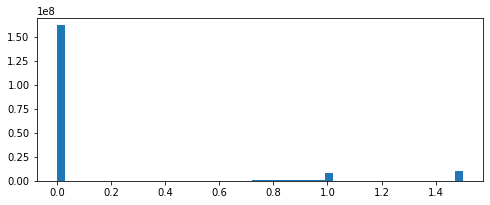

In [94]:
plt.figure(figsize=(8, 3))
plt.hist(X_features_train.values.flatten().clip(-1.5, 1.5), bins=50)
plt.show()

In [95]:
X_features_train.shape

(950525, 202)

In [113]:
import logging
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)

In [96]:
import torch
import pytorch_lightning as pl

In [97]:
from tqdm.auto import tqdm

In [98]:
def get_train_dataloader(se, data, batch_size, num_workers):
    def gen_batches(data):
        sample_len = se.hparams.history_size + se.hparams.predict_size
        for batch_ix in tqdm(data.reset_index('store_id')['store_id'].drop_duplicates().values):
            df = data.loc[batch_ix].values
            T, C = df.shape
            for i in range(0, T - sample_len):
                yield torch.from_numpy(df[i:i + sample_len].astype(np.float32))

    all_batches = torch.stack(list(gen_batches(data)))

    return torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(all_batches),
        shuffle=True,
        batch_size=batch_size,
        persistent_workers=False,
        num_workers=num_workers,
    )

def get_valid_dataloader(se, data, batch_size, num_workers):
    def gen_batches(data):
        for batch_ix in tqdm(data.reset_index('store_id')['store_id'].drop_duplicates().values):
            df = data.loc[batch_ix].values
            yield torch.from_numpy(df.astype(np.float32))
    
    all_batches = list(gen_batches(data))
    all_lenghts = [len(t) for t in all_batches]
    all_batches = torch.nn.utils.rnn.pad_sequence(all_batches, batch_first=True)
    
    return torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(all_batches),
        batch_size=batch_size,
        num_workers=num_workers,
    ), all_lenghts

In [100]:
train_dataloader = get_train_dataloader(stream_encoder, X_features_train, 128, 12)

  0%|          | 0/13658 [00:00<?, ?it/s]

In [101]:
valid_dataloader, val_lengths = get_valid_dataloader(stream_encoder, X_features_train, 512, 0)

  0%|          | 0/13658 [00:00<?, ?it/s]

In [102]:
np.sum(val_lengths), X_features_train.shape

(950525, (950525, 202))

In [103]:
next(iter(train_dataloader))[0].shape, next(iter(valid_dataloader))[0].shape, 

(torch.Size([128, 24, 202]), torch.Size([512, 72, 202]))

In [104]:
len(train_dataloader), len(valid_dataloader)

(4882, 27)

In [108]:
stream_encoder = StreamEncoder(
    history_size=21, predict_size=3,
    in_channels=202, clip_range=(-1.5, 1.5),
    z_channels=32, c_channels=64, var_gamma_z=0.5, var_gamma_c=0.2,
    lr=0.001, weight_decay=0.000,
    step_size=10, gamma=0.9,
    cpc_w=0.05, cov_z_w=1.0, var_z_w=2.0, cov_c_w=0.1, var_c_w=0.1,
    plot_samples=[0],
)

In [109]:
trainer = pl.Trainer(
    gpus=[3],
    max_epochs=3,
    val_check_interval=1000,
    log_every_n_steps=50,
    progress_bar_refresh_rate=50, weights_summary=None,
    logger=pl.loggers.TensorBoardLogger(
        save_dir='lightning_logs/',
        default_hp_metric=False,
    )
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [110]:
trainer.fit(stream_encoder, train_dataloader=train_dataloader, val_dataloaders=valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Tuning

In [111]:
def r_exp(a, b):
    a = np.log(a)
    b = np.log(b)
    
    return np.exp(np.random.random(1)[0] * (b - a) + a)

In [114]:
for i in range(5):
    params = dict(
        lr=r_exp(0.00001, 0.1),
        weight_decay=0.0 if np.random.random(1)[0] > 0.5 else r_exp(0.00001, 0.01),
        cpc_w=r_exp(0.00001, 5),
        cov_z_w=r_exp(0.00001, 5),
        var_z_w=r_exp(0.00001, 5),
        cov_c_w=r_exp(0.00001, 5),
        var_c_w=r_exp(0.00001, 5),
    )
    print(f'[{i:04d}] - start', end='')
    stream_encoder = StreamEncoder(
        history_size=21, predict_size=3,
        in_channels=202, clip_range=(-1.5, 1.5),
        z_channels=32, c_channels=64, var_gamma_z=0.5, var_gamma_c=0.2,
        step_size=10, gamma=0.9,
        **params,
    )
    trainer = pl.Trainer(
        gpus=[3],
        max_epochs=3,
        val_check_interval=1000,
        log_every_n_steps=50,
        progress_bar_refresh_rate=0, weights_summary=None,
        logger=pl.loggers.TensorBoardLogger(
            save_dir='lightning_logs/',
            default_hp_metric=False,
        )
    )

    trainer.fit(stream_encoder, train_dataloader=train_dataloader, val_dataloaders=valid_dataloader)
    print('- done')

[0000] - startdone
[0001] - startdone
[0002] - startdone
[0003] - startdone
[0004] - startdone


In [921]:
stream_encoder.eval()

StreamEncoder(
  (input_model): InputNorm(
    (bn): TBatchNorm(202, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_encoder): Sequential(
    (0): Linear(in_features=202, out_features=32, bias=True)
    (1): TBatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (ar_rnn): GRU(32, 64, batch_first=True)
  (lin_predictors): ModuleList(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
  )
  (reg_bn_z): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (reg_bn_c): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
)

In [922]:
with torch.no_grad():
    x, z, c = stream_encoder(next(iter(valid_dataloader))[0])

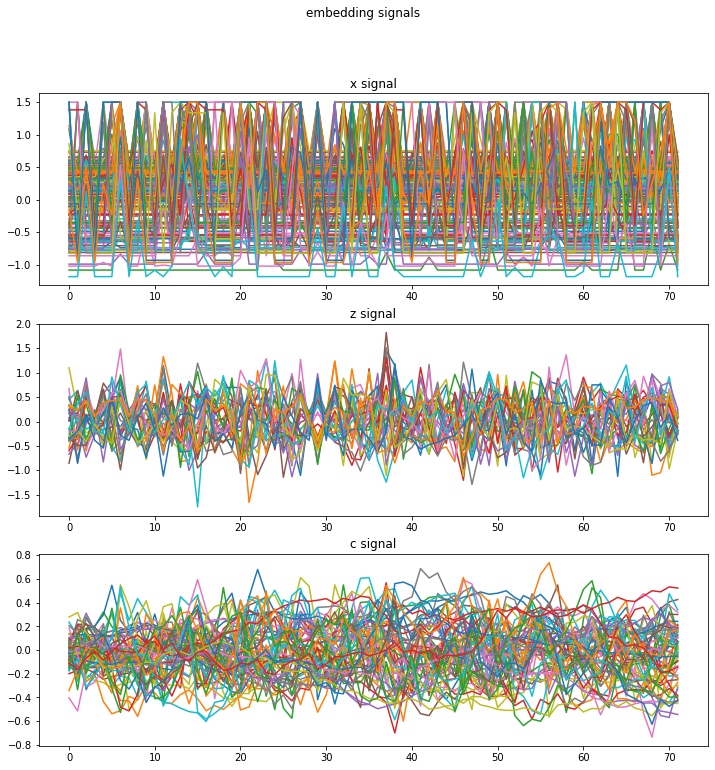

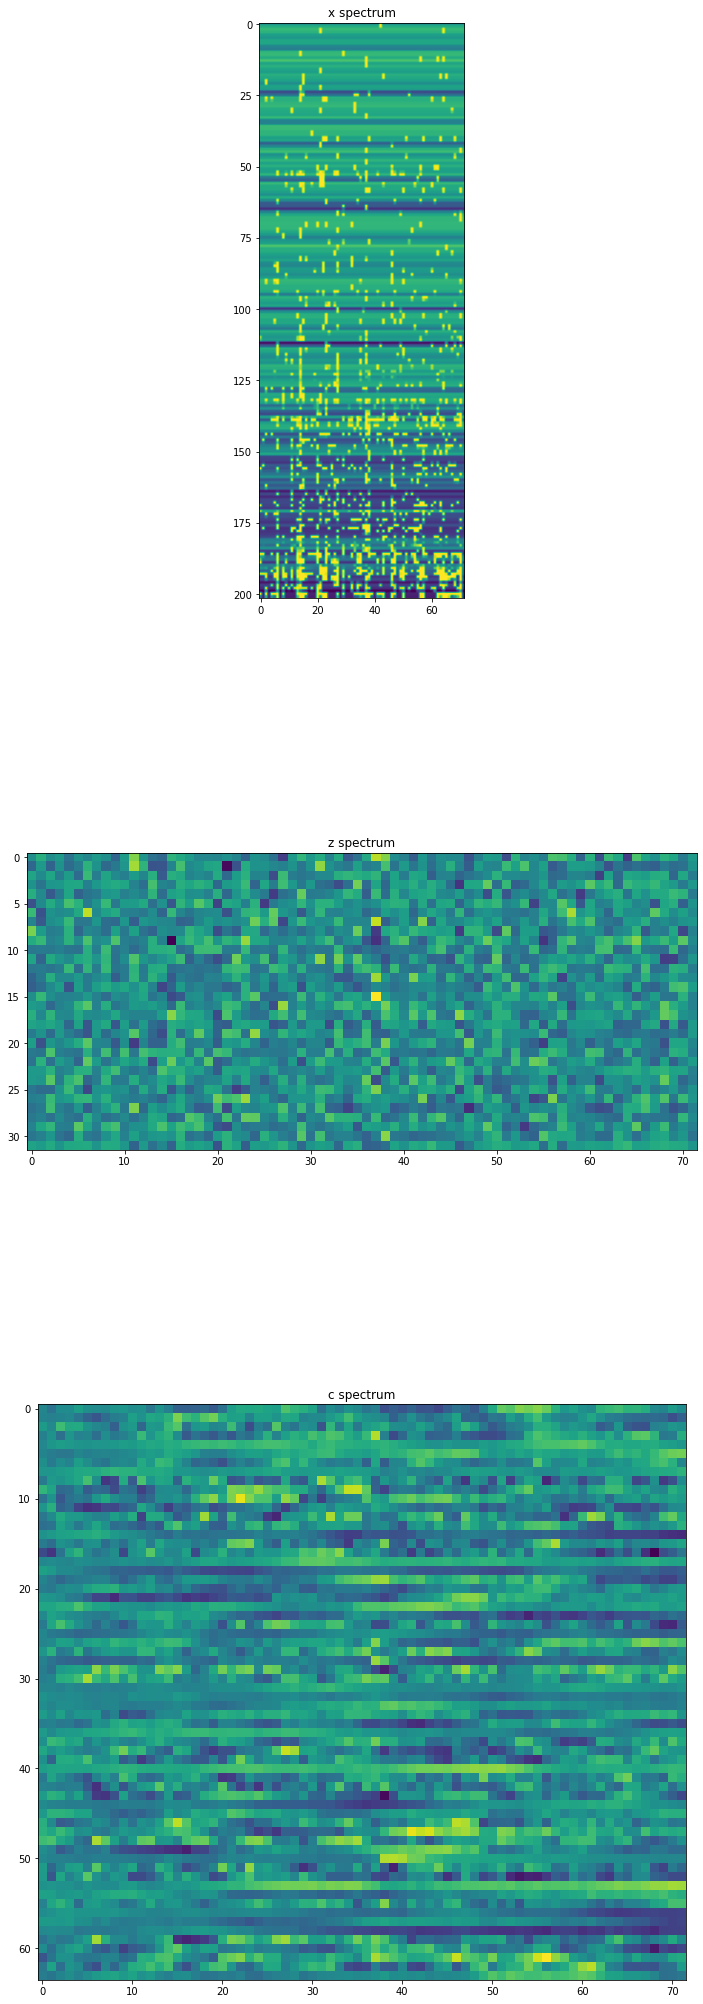

In [923]:
pos = 0
stream_encoder.plot_xzc(x[pos:], z[pos:], c[pos:], log=False)

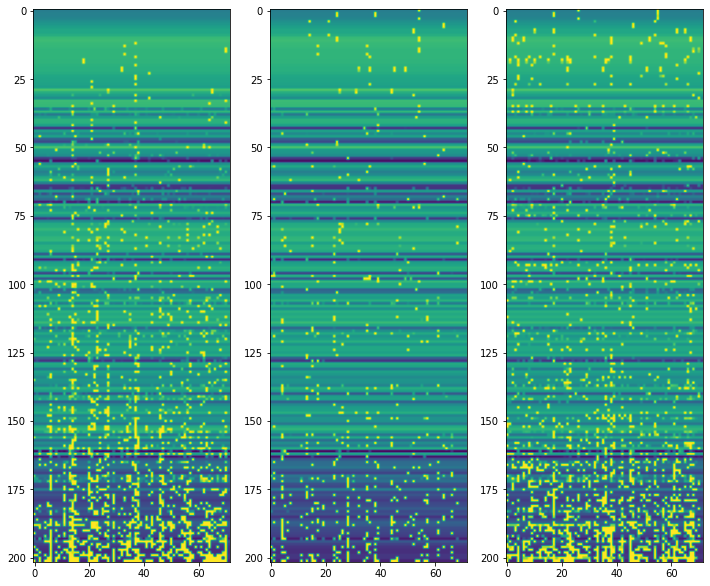

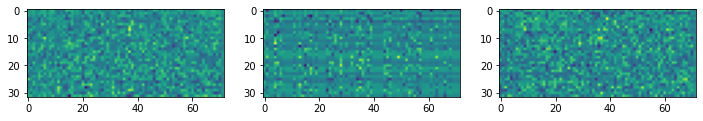

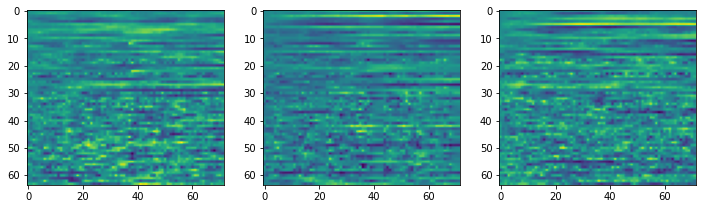

In [924]:
_, axs = plt.subplots(1, 3, figsize=(12, 12))
axs[0].imshow(x[0][:, torch.argsort(x[0].mean(dim=0) + 20 * x[0].std(dim=0))].T.numpy())
axs[1].imshow(x[1][:, torch.argsort(x[0].mean(dim=0) + 20 * x[0].std(dim=0))].T.numpy())
axs[2].imshow(x[2][:, torch.argsort(x[0].mean(dim=0) + 20 * x[0].std(dim=0))].T.numpy())
plt.show()

_, axs = plt.subplots(1, 3, figsize=(12, 5))
axs[0].imshow(z[0][:, torch.argsort(z[0].mean(dim=0) + 20 * z[0].std(dim=0))].T.numpy())
axs[1].imshow(z[1][:, torch.argsort(z[0].mean(dim=0) + 20 * z[0].std(dim=0))].T.numpy())
axs[2].imshow(z[2][:, torch.argsort(z[0].mean(dim=0) + 20 * z[0].std(dim=0))].T.numpy())
plt.show()

_, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].imshow(c[0][:, torch.argsort(c[0].mean(dim=0) + 20 * c[0].std(dim=0))].T.numpy())
axs[1].imshow(c[1][:, torch.argsort(c[0].mean(dim=0) + 20 * c[0].std(dim=0))].T.numpy())
axs[2].imshow(c[2][:, torch.argsort(c[0].mean(dim=0) + 20 * c[0].std(dim=0))].T.numpy())
plt.show()


In [925]:
stream_encoder.to('cpu')

StreamEncoder(
  (input_model): InputNorm(
    (bn): TBatchNorm(202, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_encoder): Sequential(
    (0): Linear(in_features=202, out_features=32, bias=True)
    (1): TBatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (ar_rnn): GRU(32, 64, batch_first=True)
  (lin_predictors): ModuleList(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
  )
  (reg_bn_z): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (reg_bn_c): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
)

In [926]:
inference_dataloader, inference_lengths = get_valid_dataloader(stream_encoder, X_features_train, 20000, 0)

for batch in inference_dataloader:
    with torch.no_grad():
        x_feat_train, z_feat_train, c_feat_train = stream_encoder(batch[0])

Z_feat_train = pd.DataFrame(torch.cat([d[:l] for d, l in zip(z_feat_train, inference_lengths)], dim=0).numpy(),
                            index=X_features_train.index)
C_feat_train = pd.DataFrame(torch.cat([d[:l] for d, l in zip(c_feat_train, inference_lengths)], dim=0).numpy(),
                            index=X_features_train.index)

  0%|          | 0/13658 [00:00<?, ?it/s]

In [927]:
inference_dataloader, inference_lengths = get_valid_dataloader(stream_encoder, X_features_valid, 20000, 0)

for batch in inference_dataloader:
    with torch.no_grad():
        x_feat_valid, z_feat_valid, c_feat_valid = stream_encoder(batch[0])

Z_feat_valid = pd.DataFrame(torch.cat([d[:l] for d, l in zip(z_feat_valid, inference_lengths)], dim=0).numpy(),
                            index=X_features_valid.index)
C_feat_valid = pd.DataFrame(torch.cat([d[:l] for d, l in zip(c_feat_valid, inference_lengths)], dim=0).numpy(),
                            index=X_features_valid.index)

  0%|          | 0/13757 [00:00<?, ?it/s]

In [928]:
inference_dataloader, inference_lengths = get_valid_dataloader(stream_encoder, X_features_test, 20000, 0)

for batch in inference_dataloader:
    with torch.no_grad():
        x_feat_test, z_feat_test, c_feat_test = stream_encoder(batch[0])

Z_feat_test = pd.DataFrame(torch.cat([d[:l] for d, l in zip(z_feat_test, inference_lengths)], dim=0).numpy(),
                            index=X_features_test.index)
C_feat_test = pd.DataFrame(torch.cat([d[:l] for d, l in zip(c_feat_test, inference_lengths)], dim=0).numpy(),
                            index=X_features_test.index)

  0%|          | 0/13803 [00:00<?, ?it/s]

In [929]:
reg_model = Ridge(alpha=0.1, fit_intercept=False)
# reg_model = LinearRegression()
reg_model.fit(
    np.clip(
        pd.concat([
            X_train,
            C_feat_train,
#             X_features_train,
#             X_features_train.groupby('store_id').shift(1),
#             X_features_train.groupby('store_id').shift(2),
#             X_features_train.groupby('store_id').shift(3),
#             X_features_train.groupby('store_id').shift(7),
        ], axis=1).reindex(X_train.index).fillna(0).values, -2.5, 2.5),
    np.clip(y_train.values, -2.5, 2.5),
)

Ridge(alpha=0.1, fit_intercept=False)

000407ff98


0.000  0.100  0.200  0.300  0.400  0.500  0.600  0.700  0.800  0.900  \
0 -52.032 -0.109 -0.084 -0.069 -0.056 -0.045 -0.034 -0.022 -0.006  0.017   

   1.000  
0  0.255

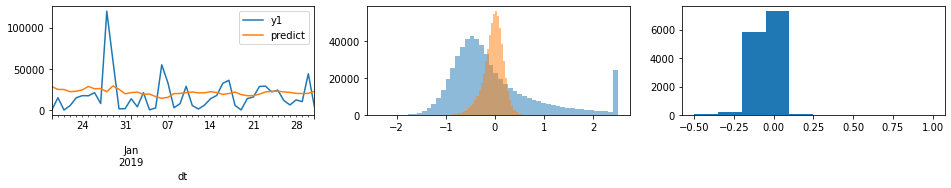

In [930]:
_ = predict(reg_model, pd.concat([
            X_train,
            C_feat_train,
#             X_features_train,
#             X_features_train.groupby('store_id').shift(1),
#             X_features_train.groupby('store_id').shift(2),
#             X_features_train.groupby('store_id').shift(3),
#             X_features_train.groupby('store_id').shift(7),
        ], axis=1).reindex(X_train.index).fillna(0), y_train, df_y_train)

000407ff98


0.000  0.100  0.200  0.300  0.400  0.500  0.600  0.700  0.800  0.900  \
0 -5,984.546 -0.169 -0.127 -0.104 -0.088 -0.074 -0.062 -0.049 -0.033 -0.011   

   1.000  
0  0.166

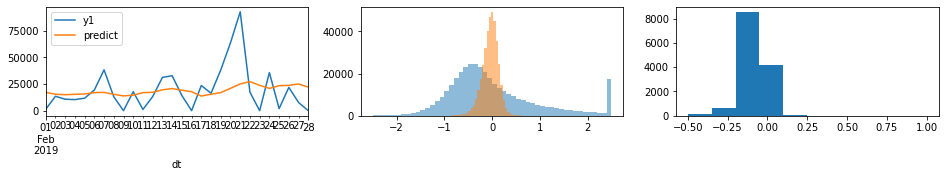

In [931]:
t = predict(reg_model, pd.concat([
            X_valid,
            C_feat_valid,
#             X_features_valid.iloc[:, :],
#             X_features_valid.groupby('store_id').shift(1),
#             X_features_valid.groupby('store_id').shift(2),
#             X_features_valid.groupby('store_id').shift(3),
#             X_features_valid.groupby('store_id').shift(7),
        ], axis=1).reindex(X_valid.index).fillna(0), y_valid, df_y_valid)

000407ff98


0.000  0.100  0.200  0.300  0.400  0.500  0.600  0.700  0.800  0.900  \
0 -44.360 -0.258 -0.174 -0.135 -0.110 -0.090 -0.073 -0.056 -0.036 -0.007   

   1.000  
0  0.277

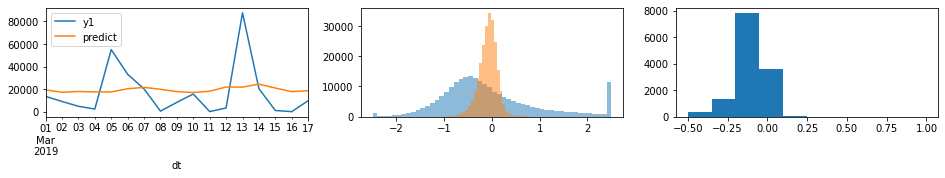

In [932]:
_ = predict(reg_model, pd.concat([
            X_test,
            C_feat_test,
#             X_features_test.iloc[:, :],
#             X_features_test.groupby('store_id').shift(1),
#             X_features_test.groupby('store_id').shift(2),
#             X_features_test.groupby('store_id').shift(3),
#             X_features_test.groupby('store_id').shift(7),
        ], axis=1).reindex(X_test.index).fillna(0), y_test, df_y_test)

In [933]:
x = np.arange(5)

In [934]:
x

array([0, 1, 2, 3, 4])

In [935]:
x.std(ddof=1)

1.5811388300841898

In [936]:
(((x ** 2).sum() - x.sum() ** 2 / 5) / 4) ** 0.5

1.5811388300841898